In [8]:
import pandas as pd
import numpy as np
import os
import psycopg2
import sqlalchemy
import string
import spacy
from spacy.symbols import ORTH
import scispacy
from collections import Counter
import re
from datetime import date, datetime, timedelta
import random
from sklearn.model_selection import GroupShuffleSplit, StratifiedShuffleSplit
from spellchecker import SpellChecker
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [9]:
dbschema='mimiciii'
cnx = sqlalchemy.create_engine('postgresql+psycopg2://btvdksxhyqtmjs:74db647f02a6f661c9a9ef888e24cebe9b17cfd2cc7566c51556096ec9977964\
@ec2-54-211-255-161.compute-1.amazonaws.com/dc8973qq7atsb1'
                    # connect_args={'options': '-csearch_path={}'.format(dbschema)}
                    )

In [10]:
sqlalchemy.inspect(cnx).has_table('ADMISSIONS')

True

In [11]:
sql = """
  SELECT
      subject_id, hadm_id, ethnicity, diagnosis, admittime, dischtime, deathtime, admission_type
  FROM "ADMISSIONS"
  WHERE admission_type NOT IN ('NEWBORN')
  ORDER BY subject_id, admittime
  --LIMIT 100;
"""

df_adm = pd.read_sql_query(sqlalchemy.text(sql), cnx)
print(df_adm.shape)
df_adm.head(20)

(129, 8)


,subject_id,hadm_id,ethnicity,diagnosis,admittime,dischtime,deathtime,admission_type
0,10006,142345,BLACK/AFRICAN AMERICAN,SEPSIS,2164-10-23 21:09:00,2164-11-01 17:15:00,None,EMERGENCY
1,10011,105331,UNKNOWN/NOT SPECIFIED,HEPATITIS B,2126-08-14 22:32:00,2126-08-28 18:59:00,2126-08-28 18:59:00,EMERGENCY
2,10013,165520,UNKNOWN/NOT SPECIFIED,SEPSIS,2125-10-04 23:36:00,2125-10-07 15:13:00,2125-10-07 15:13:00,EMERGENCY
3,10017,199207,WHITE,HUMERAL FRACTURE,2149-05-26 17:19:00,2149-06-03 18:42:00,None,EMERGENCY
4,10019,177759,WHITE,ALCOHOLIC HEPATITIS,2163-05-14 20:43:00,2163-05-15 12:00:00,2163-05-15 12:00:00,EMERGENCY
5,10026,103770,WHITE,STROKE/TIA,2195-05-17 07:39:00,2195-05-24 11:45:00,None,EMERGENCY
6,10027,199395,WHITE,MITRAL REGURGITATION;CORONARY ARTERY DISEASE\...,2190-07-13 07:15:00,2190-07-25 14:00:00,None,ELECTIVE
7,10029,132349,WHITE,SYNCOPE;TELEMETRY,2139-09-22 10:58:00,2139-10-02 14:29:00,None,EMERGENCY
8,10032,140372,WHITE,RIGHT HUMEROUS FRACTURE,2138-04-02 19:52:00,2138-04-15 14:35:00,None,EMERGENCY
9,10033,157235,WHITE,RENAL FAILIURE-SYNCOPE-HYPERKALEMIA,2132-12-05 02:46:00,2132-12-08 15:15:00,None,EMERGENCY


In [12]:
df_adm['next_admittime'] = df_adm.groupby('subject_id').admittime.shift(-1)
df_adm['next_admission_type'] = df_adm.groupby('subject_id').admission_type.shift(-1)
df_adm.head(20)

,subject_id,hadm_id,ethnicity,diagnosis,admittime,dischtime,deathtime,admission_type,next_admittime,next_admission_type
0,10006,142345,BLACK/AFRICAN AMERICAN,SEPSIS,2164-10-23 21:09:00,2164-11-01 17:15:00,None,EMERGENCY,NaN,NaN
1,10011,105331,UNKNOWN/NOT SPECIFIED,HEPATITIS B,2126-08-14 22:32:00,2126-08-28 18:59:00,2126-08-28 18:59:00,EMERGENCY,NaN,NaN
2,10013,165520,UNKNOWN/NOT SPECIFIED,SEPSIS,2125-10-04 23:36:00,2125-10-07 15:13:00,2125-10-07 15:13:00,EMERGENCY,NaN,NaN
3,10017,199207,WHITE,HUMERAL FRACTURE,2149-05-26 17:19:00,2149-06-03 18:42:00,None,EMERGENCY,NaN,NaN
4,10019,177759,WHITE,ALCOHOLIC HEPATITIS,2163-05-14 20:43:00,2163-05-15 12:00:00,2163-05-15 12:00:00,EMERGENCY,NaN,NaN
5,10026,103770,WHITE,STROKE/TIA,2195-05-17 07:39:00,2195-05-24 11:45:00,None,EMERGENCY,NaN,NaN
6,10027,199395,WHITE,MITRAL REGURGITATION;CORONARY ARTERY DISEASE\...,2190-07-13 07:15:00,2190-07-25 14:00:00,None,ELECTIVE,NaN,NaN
7,10029,132349,WHITE,SYNCOPE;TELEMETRY,2139-09-22 10:58:00,2139-10-02 14:29:00,None,EMERGENCY,NaN,NaN
8,10032,140372,WHITE,RIGHT HUMEROUS FRACTURE,2138-04-02 19:52:00,2138-04-15 14:35:00,None,EMERGENCY,NaN,NaN
9,10033,157235,WHITE,RENAL FAILIURE-SYNCOPE-HYPERKALEMIA,2132-12-05 02:46:00,2132-12-08 15:15:00,None,EMERGENCY,NaN,NaN


In [22]:
# get rows where next admission is elective and replace with naT or nan
rows = df_adm.next_admission_type == 'ELECTIVE'
df_adm.loc[rows,'next_admittime'] = pd.NaT
df_adm.loc[rows,'next_admission_type'] = np.NaN

In [23]:
# sort by subject_ID and admission date
# it is safer to sort right before the fill in case something changed the order above
df_adm = df_adm.sort_values(['subject_id','admittime'])
# back fill (this will take a little while)
df_adm[['next_admittime','next_admission_type']] = df_adm.groupby(['subject_id'])[['next_admittime','next_admission_type']].fillna(method = 'bfill')

In [24]:
df_adm.next_admittime

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
      ... 
124    NaN
125    NaN
126    NaN
127    NaN
128    NaN
Name: next_admittime, Length: 129, dtype: object

In [26]:
# convert the 'Date' column to datetime format
df_adm['admittime']= pd.to_datetime(df_adm['admittime'])
df_adm['dischtime']= pd.to_datetime(df_adm['dischtime'])
df_adm['deathtime']= pd.to_datetime(df_adm['deathtime'])
df_adm['next_admittime']= pd.to_datetime(df_adm['next_admittime'])

In [27]:
df_adm['days_next_admit']=  (df_adm['next_admittime'] - df_adm['dischtime']).dt.total_seconds()/(24*60*60)

In [28]:
print(len(df_adm))
df_adm.head(100)

129


,subject_id,hadm_id,ethnicity,diagnosis,admittime,dischtime,deathtime,admission_type,next_admittime,next_admission_type,days_next_admit
0,10006,142345,BLACK/AFRICAN AMERICAN,SEPSIS,2164-10-23 21:09:00,2164-11-01 17:15:00,NaT,EMERGENCY,NaT,NaN,NaN
1,10011,105331,UNKNOWN/NOT SPECIFIED,HEPATITIS B,2126-08-14 22:32:00,2126-08-28 18:59:00,2126-08-28 18:59:00,EMERGENCY,NaT,NaN,NaN
2,10013,165520,UNKNOWN/NOT SPECIFIED,SEPSIS,2125-10-04 23:36:00,2125-10-07 15:13:00,2125-10-07 15:13:00,EMERGENCY,NaT,NaN,NaN
3,10017,199207,WHITE,HUMERAL FRACTURE,2149-05-26 17:19:00,2149-06-03 18:42:00,NaT,EMERGENCY,NaT,NaN,NaN
4,10019,177759,WHITE,ALCOHOLIC HEPATITIS,2163-05-14 20:43:00,2163-05-15 12:00:00,2163-05-15 12:00:00,EMERGENCY,NaT,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
95,42135,102203,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,FAILURE TO THRIVE,2127-07-23 15:21:00,2127-08-04 16:00:00,NaT,EMERGENCY,2127-10-06 21:00:00,EMERGENCY,63.208333
96,42135,117105,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,HEPATIC ENCEP,2127-10-06 21:00:00,2127-10-28 12:50:00,2127-10-28 12:50:00,EMERGENCY,NaT,NaN,NaN
97,42199,178513,WHITE,CHEST PAIN,2117-03-21 12:55:00,2117-03-31 12:10:00,NaT,EMERGENCY,NaT,NaN,NaN
98,42231,171878,WHITE,RENAL CANCER/SDA,2102-08-29 07:15:00,2102-09-06 16:20:00,NaT,ELECTIVE,NaT,NaN,NaN


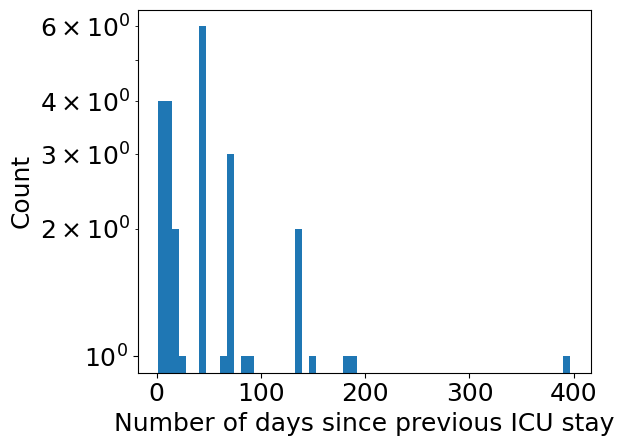

In [29]:
matplotlib.rcParams.update({'font.size': 18})

plt.hist(df_adm['days_next_admit'], bins=60)
plt.ylabel('Count')
plt.xlabel('Number of days since previous ICU stay')
plt.yscale('log')
plt.tight_layout()
plt.savefig('readmission-histogram.pdf')

In [30]:
df_adm['30d_unplan_readmit'] = 'N'
df_adm.loc[df_adm['days_next_admit'] < 30, '30d_unplan_readmit'] = 'Y'

In [31]:
df_adm.head(50)

,subject_id,hadm_id,ethnicity,diagnosis,admittime,dischtime,deathtime,admission_type,next_admittime,next_admission_type,days_next_admit,30d_unplan_readmit
0,10006,142345,BLACK/AFRICAN AMERICAN,SEPSIS,2164-10-23 21:09:00,2164-11-01 17:15:00,NaT,EMERGENCY,NaT,NaN,NaN,N
1,10011,105331,UNKNOWN/NOT SPECIFIED,HEPATITIS B,2126-08-14 22:32:00,2126-08-28 18:59:00,2126-08-28 18:59:00,EMERGENCY,NaT,NaN,NaN,N
2,10013,165520,UNKNOWN/NOT SPECIFIED,SEPSIS,2125-10-04 23:36:00,2125-10-07 15:13:00,2125-10-07 15:13:00,EMERGENCY,NaT,NaN,NaN,N
3,10017,199207,WHITE,HUMERAL FRACTURE,2149-05-26 17:19:00,2149-06-03 18:42:00,NaT,EMERGENCY,NaT,NaN,NaN,N
4,10019,177759,WHITE,ALCOHOLIC HEPATITIS,2163-05-14 20:43:00,2163-05-15 12:00:00,2163-05-15 12:00:00,EMERGENCY,NaT,NaN,NaN,N
5,10026,103770,WHITE,STROKE/TIA,2195-05-17 07:39:00,2195-05-24 11:45:00,NaT,EMERGENCY,NaT,NaN,NaN,N
6,10027,199395,WHITE,MITRAL REGURGITATION;CORONARY ARTERY DISEASE\...,2190-07-13 07:15:00,2190-07-25 14:00:00,NaT,ELECTIVE,NaT,NaN,NaN,N
7,10029,132349,WHITE,SYNCOPE;TELEMETRY,2139-09-22 10:58:00,2139-10-02 14:29:00,NaT,EMERGENCY,NaT,NaN,NaN,N
8,10032,140372,WHITE,RIGHT HUMEROUS FRACTURE,2138-04-02 19:52:00,2138-04-15 14:35:00,NaT,EMERGENCY,NaT,NaN,NaN,N
9,10033,157235,WHITE,RENAL FAILIURE-SYNCOPE-HYPERKALEMIA,2132-12-05 02:46:00,2132-12-08 15:15:00,NaT,EMERGENCY,NaT,NaN,NaN,N


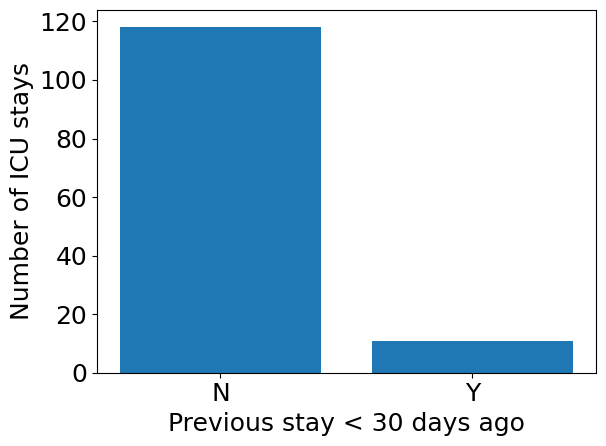

In [32]:
#df_adm['30d_unplan_readmit'].value_counts().plot(kind='bar')
plt.bar(df_adm['30d_unplan_readmit'].unique(),height=df_adm['30d_unplan_readmit'].value_counts())
plt.ylabel('Number of ICU stays')
plt.xlabel('Previous stay < 30 days ago')
plt.tight_layout()
plt.savefig('30d-readmission-bar.pdf')

In [33]:
readmit_count = df_adm.subject_id[(df_adm['30d_unplan_readmit']) == 'Y'].count()
ratio = readmit_count/df_adm['30d_unplan_readmit'].count()
ratio

0.08527131782945736

<AxesSubplot:>

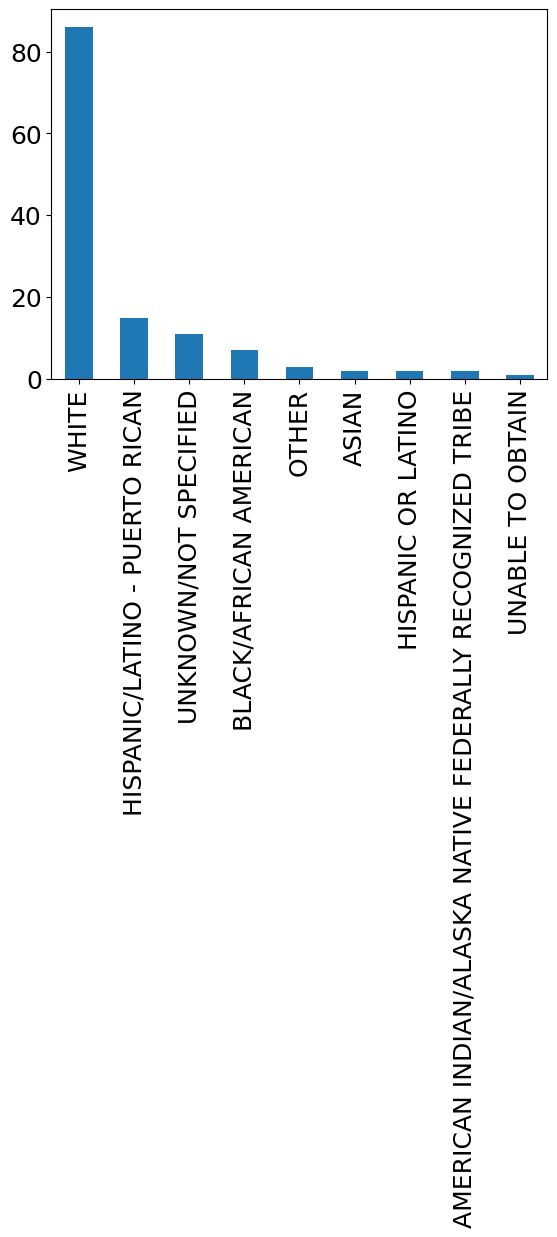

In [34]:
df_adm['ethnicity'].value_counts().plot(kind='bar')

In [35]:
sorted(df_adm.ethnicity.unique())

['AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE',
 'ASIAN',
 'BLACK/AFRICAN AMERICAN',
 'HISPANIC OR LATINO',
 'HISPANIC/LATINO - PUERTO RICAN',
 'OTHER',
 'UNABLE TO OBTAIN',
 'UNKNOWN/NOT SPECIFIED',
 'WHITE']

In [36]:
asian = dict.fromkeys(['ASIAN','ASIAN - ASIAN INDIAN','ASIAN - CAMBODIAN','ASIAN - CHINESE','ASIAN - FILIPINO',
 'ASIAN - JAPANESE',
 'ASIAN - KOREAN',
 'ASIAN - OTHER',
 'ASIAN - THAI',
 'ASIAN - VIETNAMESE',
 'MIDDLE EASTERN'], 'asian')    
white = dict.fromkeys([ 'WHITE', 'WHITE - BRAZILIAN', 'WHITE - EASTERN EUROPEAN', 'WHITE - OTHER EUROPEAN', 'WHITE - RUSSIAN'], 'white')
black = dict.fromkeys([ 'BLACK/AFRICAN', 'BLACK/AFRICAN AMERICAN', 'BLACK/CAPE VERDEAN','BLACK/HAITIAN'], 'black')
hispanic = dict.fromkeys([ 'HISPANIC OR LATINO', 'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)', 'HISPANIC/LATINO - COLOMBIAN',
 'HISPANIC/LATINO - CUBAN',
 'HISPANIC/LATINO - DOMINICAN',
 'HISPANIC/LATINO - GUATEMALAN',
 'HISPANIC/LATINO - HONDURAN',
 'HISPANIC/LATINO - MEXICAN',
 'HISPANIC/LATINO - PUERTO RICAN',
 'HISPANIC/LATINO - SALVADORAN',
 'PORTUGUESE',
 'SOUTH AMERICAN'], 'hispanic')

df_adm = df_adm.replace(asian)
df_adm = df_adm.replace(white)
df_adm = df_adm.replace(black)
df_adm = df_adm.replace(hispanic)

allowed_vals = ['asian', 'black', 'white', 'hispanic']
df_adm.loc[~df_adm['ethnicity'].isin(allowed_vals), 'ethnicity'] = "other"
sorted(df_adm.ethnicity.unique())

['asian', 'black', 'hispanic', 'other', 'white']

<AxesSubplot:>

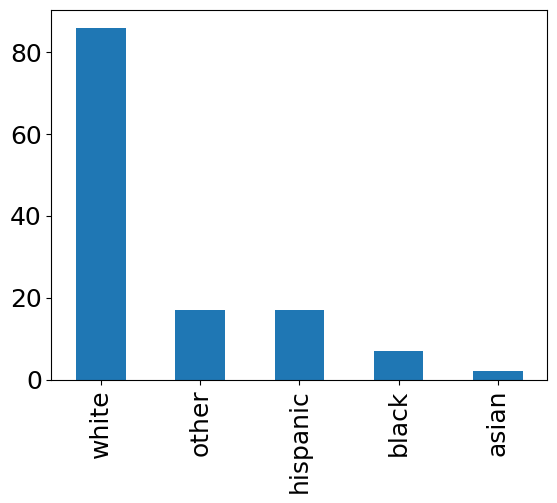

In [37]:
df_adm['ethnicity'].value_counts().plot(kind='bar')

In [39]:
df_adm.diagnosis = df_adm.diagnosis.apply(str)
print(df_adm.diagnosis)

0                                                 SEPSIS
1                                            HEPATITIS B
2                                                 SEPSIS
3                                       HUMERAL FRACTURE
4                                    ALCOHOLIC HEPATITIS
                             ...                        
124                                 PERICARDIAL EFFUSION
125                                ALTERED MENTAL STATUS
126    ACUTE RESPIRATORY DISTRESS SYNDROME;ACUTE RENA...
127                                          BRADYCARDIA
128                                          CHOLANGITIS
Name: diagnosis, Length: 129, dtype: object


In [40]:
df_adm_csv = df_adm[['subject_id','hadm_id', 'ethnicity','diagnosis','admission_type','30d_unplan_readmit']]